### Script for summarizing tele-critical care article searches
#### Reads exported xml files from keyword searches in IU One Search and summarizes information by creating wordclouds from clusters of topics

by R.K.Fischer, rkfische@iu.edu

1. Read in and parse xml files (which were exported from separate keyword searches using IU one search); each xml file has hundreds to thousands of article records.  
2. Filter articles that contain a subject word in the bacteria_list; tokenize the filtered articles' abstract text.  
3. Group tokens into topics using sklearn's NMF algorithm.  Number of topics is determined by dividing the product of number of articles and the number of words by the non-zero values in the tfidf matrix. Originally, capped each search file to five NMF topics.  In each case, the topic contained 20 words each.  
4. Apply network graph technology to group topics. Topics linked with their words were brought into a network graph application, Gephi, and grouped using the modularity function. 
5. Create word streams from the grouped topics' words. The modularity groups were imported back and word streams were created for each group cluster.  
6. Print wordclouds as a way to summarize each cluster of topics (clusters contain 1, 2 or many topics, e.g. 20 topics are in one cluster) 

In [105]:
import xml.etree.ElementTree as ET
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np
import math
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.cm as cm

import networkx as nx
import community as community_louvain
from networkx.algorithms.community.centrality import girvan_newman

from collections import Counter
from sklearn.feature_extraction import text
from nltk.stem.porter import PorterStemmer
import re

In [106]:
#xml_files = ["disaster.xml", "tcc.xml"]
xml_files = ["tcc.xml"]
file_tags = ['t']


In [196]:
keyword_list = ['critical', 'care']

In [197]:
def create_root(file):
    tree = ET.parse(file)
    root = tree.getroot()
    return root

In [203]:
def records_with_keyword_subj(root, flag):
    text_list = []
    record_list = []
    article_count = 0
    for record in root.findall("rec"):
        article_count +=1
        try:
            subjects = record.findall("header/controlInfo/artinfo/sug/")
            keyword_flag = 0
            if len(subjects)>0:
                for subj in subjects:
                    try:
                        text_list.append(subj.text.lower().split())
                        text_words = text_list.pop()
                    except:
                        pass
                    for word in text_words:
                        if word in keyword_list:
                            # print("word matches", word)
                            keyword_flag = 1
            if keyword_flag == 1 or flag == 1:
                record_list.append(record.attrib['resultID'])
        except:
            pass
    # print(record_list)
    return [record_list, article_count]



In [204]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(["https", "http", "amp", 
                                              "theyr", "isnt", "dont", "just", "that"])

def wordsToList(strn):
    L = strn.split()
    #pat1 = r'@[A-Za-z0-9_]+'
    pat2 = r'@[\w]+'
    pat3 = r'https?://[^ ]+'
    pat4 = r'#[^ ]+'    
    combined_pat = r'|'.join((pat2,pat3,pat4))
    cleanL = []
    for e in L:
        word = ''
        stripped = re.sub(combined_pat, '', e)
        letters_only = re.sub("[^a-zA-Z]",'', stripped)
        if len(letters_only)>1 and len(letters_only) <20:          
            cleanL.append(letters_only.lower())
    return cleanL

stemmer = PorterStemmer()
def tokenize(text):
        tokens = wordsToList(text)
        words = [x for x in tokens if x not in my_stop_words]
        #stems = [stemmer.stem(item) for item in words]
        return words


In [205]:
def get_abstracts(record_list, root):
    tag_dict = {'au':'author', 'atl': 'title', 'subj': 'subject', 'affil': 'affiliation',
               'fmt': 'format'}
    ab_text_list = []
    rec_nbr=[]
    for record in root.findall("rec"):
        if record.attrib['resultID'] in record_list:
            try:
                abstract = record.find("header/controlInfo/artinfo/ab").text
                #There may be more than one ab per article
                if abstract not in ab_text_list:
                    ab_text_list.append(abstract)
                    rec_nbr.append(record.attrib['resultID'])
            except:
                pass
    # print(rec_nbr)
    return [ab_text_list, rec_nbr]
    

In [206]:
def topic_generation(text_list, tag, rec_nbr, number_of_topics, number_of_tokens):
    topic_list = []
    search_list = []
    vect = TfidfVectorizer(smooth_idf=True, sublinear_tf=False, norm=None, analyzer='word',
                           max_features=3000, min_df=2, ngram_range=(1,1),
                          stop_words=my_stop_words, strip_accents ='ascii',
                          tokenizer = tokenize)
    X = vect.fit_transform(text_list)
    feature_names = np.array(vect.get_feature_names())
    # merge the search file tag to the record number to link back to a specific article
    index_rec = [tag+str(x) for x in rec_nbr]
    # save X array into a dataframe 
    # with word tokens as columns and file record number as row index
    tf_idf_df = pd.DataFrame(X.toarray(), columns = feature_names, index=index_rec)
    
    # count the nonzero values as part of the number of topics calculation
    x_ar = X.todense()
    non_zero_values = 0
    for x in x_ar:
        non_zero_values += np.count_nonzero(x)

    print("Number of abstract texts (length of text_list)",len(text_list))
    print("number of words (len of feature_names)", len(feature_names))
    print("non_zero_values", non_zero_values)
    number_of_topics = round( (len(text_list)*len(feature_names))/non_zero_values )
    print("Number of recommended topics:", number_of_topics )

    nmf = NMF(n_components=number_of_topics, solver="mu")
    W = nmf.fit_transform(X)
    H = nmf.components_
    for i, topic in enumerate(H):
        topic_words=[]
        for x in feature_names[topic.argsort()[-number_of_tokens:]]:
            topic_words.append(x)
        topic_list.append(topic_words)
        search_list.append(tag+str(i+1))
    return topic_list, search_list, tf_idf_df


In [207]:
# Main code calling the above functions

topic_word_list = []
topic_search_list = []
cnt = 0
tpc = 0
flag = 0
for file, tag in zip(xml_files, file_tags):
    print("\n", file, "tag", tag)
    root = create_root(file)
    record_list, article_count = records_with_keyword_subj(root,1)
    print("Number of total records:", article_count)
    print("Number of filtered records",len(record_list)) 
    ab_text_list, rec_nbr = get_abstracts(record_list, root)
    topic_list, search_list, tf_idf_df = topic_generation(ab_text_list, tag, rec_nbr, 5, 20)
    
    # is there risk of word columns being overwritten across xml files???????????????????
    if flag == 0:
        ab_word_vector_df = tf_idf_df.copy(deep=True)
        flag = 1
    else:
        ab_word_vector_df = pd.concat([ab_word_vector_df,tf_idf_df])   
         
    topic_word_list.append(topic_list)
    topic_search_list.append(search_list)
print("\nNumber of search result xml files" ,len(topic_word_list) )
print("\nNumber of abstracts (length of ab_word_vector_df)", len(ab_word_vector_df))
print("\nNumber of word tokens (columns in ab_word_vector_df)", len(ab_word_vector_df.columns))
print("\nNumber of topics", len(topic_search_list))

topic_dict = {}
word_cloud_list = []
for tag, search in zip(topic_search_list, topic_word_list):
    for t, s in zip(tag, search):
        # print(t, s)
        topic_dict[t]=s
    for topic in search:
        for word in topic:
            word_cloud_list.append(word)
listToStr = ' '.join([str(elem) for elem in word_cloud_list])
print("\nTotal number of topics generated:", len(topic_dict))


    


 tcc.xml tag t
Number of total records: 78
Number of filtered records 78
Number of abstract texts (length of text_list) 50
number of words (len of feature_names) 615
non_zero_values 2234
Number of recommended topics: 14

Number of search result xml files 1

Number of abstracts (length of ab_word_vector_df) 50

Number of word tokens (columns in ab_word_vector_df) 615

Number of topics 1

Total number of topics generated: 14


/usr/local/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [208]:
ab_word_vector_df = ab_word_vector_df.fillna(0)

In [209]:
ab_word_vector_df.head()

,ability,abstract,access,activity,acuity,acute,addition,additionally,address,administered,...,vitel,volume,vs,wards,way,week,work,workflows,worlds,year
t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,3.833213,0.0,0.0,0.0,0.0,0.0,0.0
t3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.322388,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
t4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
t5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
t6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
# find articles by key word sorted by tfidf
ex_word= 'care'
article_word_df = ab_word_vector_df.loc[ab_word_vector_df[ex_word]>0, [ex_word]]
print(ab_word_vector_df.iloc[1][ex_word])
print(article_word_df.sort_values(ex_word, ascending=False))

3.8047919597840383
          care
t45  13.950904
t14  13.950904
t42  13.950904
t9   12.682640
t19  12.682640
t11  12.682640
t17  12.682640
t44   8.877848
t47   7.609584
t33   5.073056
t28   5.073056
t1    5.073056
t8    5.073056
t7    5.073056
t10   5.073056
t30   3.804792
t5    3.804792
t37   3.804792
t51   3.804792
t22   3.804792
t3    3.804792
t20   3.804792
t23   2.536528
t32   2.536528
t6    2.536528
t21   2.536528
t43   2.536528
t4    2.536528
t12   2.536528
t53   1.268264
t61   1.268264
t46   1.268264
t27   1.268264
t36   1.268264
t31   1.268264
t29   1.268264
t26   1.268264
t62   1.268264


In [211]:
article_word_df.index

Index(['t1', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12',
       't14', 't17', 't19', 't20', 't21', 't22', 't23', 't26', 't27', 't28',
       't29', 't30', 't31', 't32', 't33', 't36', 't37', 't42', 't43', 't44',
       't45', 't46', 't47', 't51', 't53', 't61', 't62'],
      dtype='object')

In [212]:
def cosine_similarity(vector1, vector2):
    dot_product = sum(p*q for p,q in zip(vector1, vector2))
    magnitude = math.sqrt(sum([val**2 for val in vector1])) * math.sqrt(sum([val**2 for val in vector2]))
    if not magnitude:
        return 0
    return dot_product/magnitude

In [213]:
cosine_similarity(ab_word_vector_df.loc['t5'], ab_word_vector_df.loc['t11'])



0.09527093529598338

In [214]:
# Create a networkx graph with words and topic tags as nodes

G = nx.Graph()

for tag in topic_search_list:
    for t in tag:
        G.add_node(t, size = 100)
for words in topic_word_list:
    for word in words:
        for w in word:
            G.add_node(w, size =1)

for tag, words in zip(topic_search_list, topic_word_list):
    for t, w in zip(tag, words):
        print("*********")
        for word in w: 
            print(t, word)
            G.add_edge(t, word, weight = 1)
    
cluster = nx.clustering(G)    

*********
t1 naval
t1 program
t1 expertise
t1 involvement
t1 hospital
t1 number
t1 months
t1 intensivists
t1 medical
t1 critically
t1 ill
t1 vs
t1 outcomes
t1 care
t1 patients
t1 staffing
t1 nmcsd
t1 nhcp
t1 tcc
t1 intensivist
*********
t2 routine
t2 scalable
t2 robotics
t2 capacity
t2 supplies
t2 telemedicine
t2 national
t2 ensure
t2 critical
t2 existing
t2 term
t2 emergency
t2 future
t2 providers
t2 covid
t2 care
t2 digital
t2 netccn
t2 technologies
t2 health
*********
t3 patients
t3 impact
t3 virtual
t3 periods
t3 management
t3 admitted
t3 services
t3 los
t3 average
t3 rounding
t3 week
t3 icu
t3 vs
t3 interventions
t3 medication
t3 period
t3 total
t3 time
t3 days
t3 shift
*********
t4 terms
t4 synthesis
t4 mechanism
t4 evolution
t4 structure
t4 credentialing
t4 data
t4 teleicu
t4 medicine
t4 included
t4 including
t4 society
t4 icu
t4 given
t4 published
t4 telemedicine
t4 organizational
t4 telecritical
t4 critical
t4 care
*********
t5 manuscript
t5 methods
t5 surveillance
t5 months
t

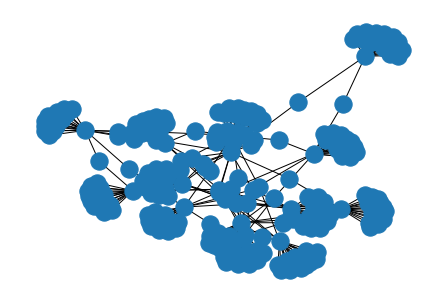

In [215]:

nx.draw(G, with_labels=False)

In [216]:
len(G)

242

In [217]:
partition = community_louvain.best_partition(G)

In [218]:
len(partition)

242

In [219]:
cluster_list = list(set(partition.values()))
len(cluster_list)

11

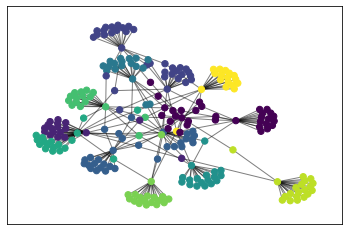

In [220]:
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [221]:
# Export graph for reading into Gephi
nx.write_gexf(G, "tccpubtopics.gexf")

In [222]:
# create a list of topic tags
topic_tags = []
for l in topic_search_list:
    for tag in l:
        topic_tags.append(tag)

Wordcloud ** naval ** for these topics: ['t1', 't7'] 

Top 5 words ['naval', 'program', 'expertise', 'involvement', 'number']


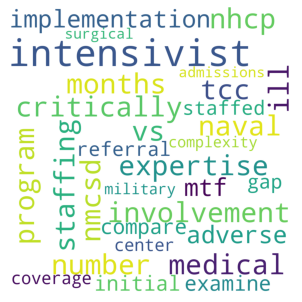

Wordcloud ** routine ** for these topics: ['t2'] 

Top 5 words ['routine', 'scalable', 'robotics', 'capacity', 'supplies']


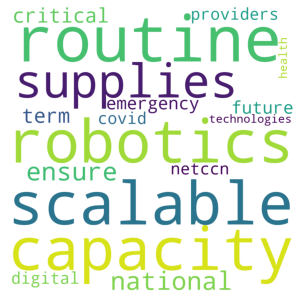

Wordcloud ** impact ** for these topics: ['t3', 't14'] 

Top 5 words ['impact', 'virtual', 'periods', 'management', 'admitted']


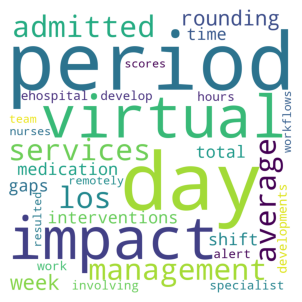

Wordcloud ** telemedicine ** for these topics: ['t4', 't12'] 

Top 5 words ['telemedicine', 'terms', 'synthesis', 'mechanism', 'evolution']


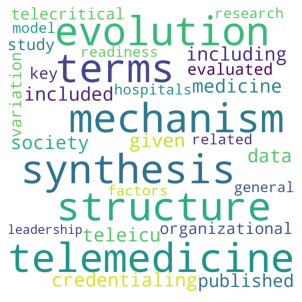

Wordcloud ** manuscript ** for these topics: ['t5'] 

Top 5 words ['manuscript', 'methods', 'surveillance', 'process', 'participants']


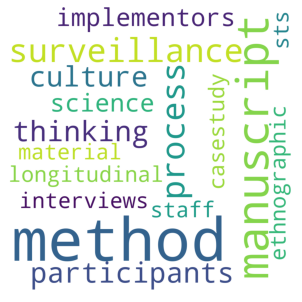

Wordcloud ** brevard ** for these topics: ['t6'] 

Top 5 words ['brevard', 'sought', 'county', 'decompensating', 'year']


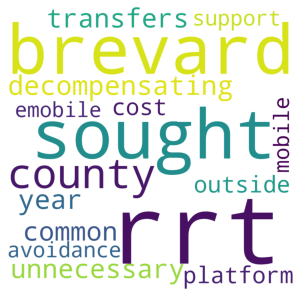

Wordcloud ** existing ** for these topics: ['t13'] 

Top 5 words ['existing', 'equipment', 'enrolled', 'pandemic', 'response']


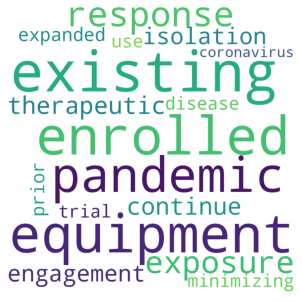

Wordcloud ** hospital ** for these topics: ['t8'] 

Top 5 words ['hospital', 'care', 'network', 'following', 'improve']


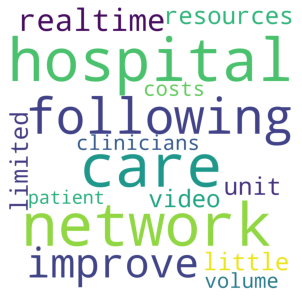

Wordcloud ** icu ** for these topics: ['t9'] 

Top 5 words ['icu', 'guided', 'auditfeedback', 'present', 'analysis']


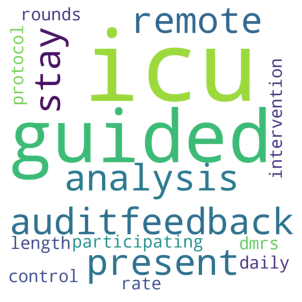

Wordcloud ** outcomes ** for these topics: ['t10'] 

Top 5 words ['outcomes', 'amsterdam', 'netherlands', 'department', 'affairs']


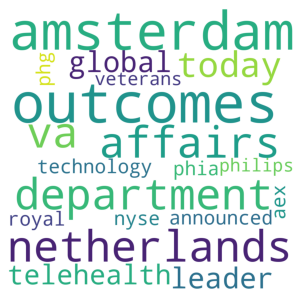

Wordcloud ** patients ** for these topics: ['t11'] 

Top 5 words ['patients', 'date', 'optimize', 'operational', 'received']


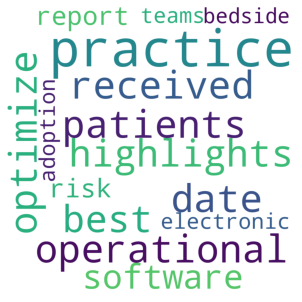

In [223]:
# print out a wordcloud for each group of topics along with the topics
# https://stackoverflow.com/questions/42322331/pythonic-way-to-find-all-elements-with-the-highest-frequency

summary_list = []
for g in cluster_list:
    word_cloud_list = []
    node_list = []
    for key in partition:
        group = partition[key]
        node = key
        if group==g and node not in topic_tags:
            word_cloud_list.append(node)
        if group==g and node in topic_tags and node not in node_list:  
            node_list.append(node)
    word_count = Counter(word_cloud_list)
    top_word_in_cluster = word_count.most_common(1)[0][0]
    top5 =  [x for x, _ in word_count.most_common(5)]
    listToStr = ' '.join([str(elem) for elem in word_cloud_list])
    wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = my_stop_words, 
                min_font_size = 10).generate(listToStr) 
    print("Wordcloud **", top_word_in_cluster, "** for these topics:", node_list, "\n")
    print("Top 5 words", top5)
    #for node in node_list:
        #print(topic_dict[node])
    summary_list.append([len(node_list),top5])

    # plot the WordCloud image                        
    plt.figure(figsize = (4, 6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()


In [224]:
summary_list.sort(key=lambda x: x[0], reverse=True)
summary_list

[[2, ['naval', 'program', 'expertise', 'involvement', 'number']],
 [2, ['impact', 'virtual', 'periods', 'management', 'admitted']],
 [2, ['telemedicine', 'terms', 'synthesis', 'mechanism', 'evolution']],
 [1, ['routine', 'scalable', 'robotics', 'capacity', 'supplies']],
 [1, ['manuscript', 'methods', 'surveillance', 'process', 'participants']],
 [1, ['brevard', 'sought', 'county', 'decompensating', 'year']],
 [1, ['existing', 'equipment', 'enrolled', 'pandemic', 'response']],
 [1, ['hospital', 'care', 'network', 'following', 'improve']],
 [1, ['icu', 'guided', 'auditfeedback', 'present', 'analysis']],
 [1, ['outcomes', 'amsterdam', 'netherlands', 'department', 'affairs']],
 [1, ['patients', 'date', 'optimize', 'operational', 'received']]]

In [225]:
# approach for calculating cosine similarity on all file combinations... time consuming to run!!!!!!!!
filtered_ab_list = ab_word_vector_df.index
xx, yy = np.meshgrid(filtered_ab_list, filtered_ab_list)
cos_list = []
df = ab_word_vector_df
for x, y in zip(xx,yy):
    for doc in x:
        if doc!=y[1]:
            cos = cosine_similarity( df.loc[doc], df.loc[y[1]] ) 
            print(doc, y[1], cos)
            cos_list.append([doc,y[1],cos])

t3 t1 0.20887898843502806
t4 t1 0.126619517567836
t5 t1 0.06563060206854775
t6 t1 0.03931020171983056
t7 t1 0.07002437554915587
t8 t1 0.17396533302216086
t9 t1 0.18702937083888657
t10 t1 0.33340786828324454
t11 t1 0.1612547461073471
t12 t1 0.12504135365692517
t14 t1 0.23859026608714803
t16 t1 0.04532358980735697
t17 t1 0.15760581764943393
t19 t1 0.2578497980741954
t20 t1 0.2958881372668279
t21 t1 0.07223962537135606
t22 t1 0.11445301134887922
t23 t1 0.09087611349177195
t24 t1 0.03050486099897877
t26 t1 0.07595986060642855
t27 t1 0.061766354045692126
t28 t1 0.11419798609019176
t29 t1 0.03860543601453487
t30 t1 0.06178969427120249
t31 t1 0.039493415633824656
t32 t1 0.06535626499538294
t33 t1 0.10663791440256751
t34 t1 0.05679667591969709
t35 t1 0.0665042823495064
t36 t1 0.07595986060642855
t37 t1 0.10439044162259423
t38 t1 0.028336555398752343
t39 t1 0.03470396745909611
t40 t1 0.027961466906688617
t41 t1 0.0
t42 t1 0.19513129345471641
t43 t1 0.25853342413511904
t44 t1 0.09606459560501224

t26 t11 0.04156224456605808
t27 t11 0.1552022423180356
t28 t11 0.2554246428537009
t29 t11 0.050493054974615155
t30 t11 0.09563823299374861
t31 t11 0.05165446663996343
t32 t11 0.06782388270506476
t33 t11 0.1323556549369349
t34 t11 0.09599210497791077
t35 t11 0.044230761143960455
t36 t11 0.04156224456605808
t37 t11 0.10529252563128068
t38 t11 0.020666573194000476
t39 t11 0.029874333936093424
t40 t11 0.020393011581928053
t41 t11 0.028545836963122854
t42 t11 0.23427801891130615
t43 t11 0.1979432444095951
t44 t11 0.13516692074249756
t45 t11 0.23950574784011092
t46 t11 0.07855112682285358
t47 t11 0.20459672543528948
t51 t11 0.04800563619598705
t53 t11 0.11036078552493832
t57 t11 0.03340939073158666
t60 t11 0.036893450454032584
t61 t11 0.043993402145258785
t62 t11 0.043993402145258785
t63 t11 0.0
t71 t11 0.06729421729510086
t1 t12 0.12504135365692517
t3 t12 0.1914275431192375
t4 t12 0.012948600893666654
t5 t12 0.06637286283964361
t6 t12 0.020439185687971494
t7 t12 0.12207682859628859
t8 t12 0

t26 t27 0.0821212695608173
t28 t27 0.02381599400035234
t29 t27 0.11037833737782304
t30 t27 0.05908177010079891
t31 t27 0.11291719522068479
t32 t27 0.14929468867194803
t33 t27 0.06483622342732015
t34 t27 0.009528863589070019
t35 t27 0.0
t36 t27 0.0821212695608173
t37 t27 0.08318279267776552
t38 t27 0.0993636511770186
t39 t27 0.1301273182802036
t40 t27 0.09804838326384188
t41 t27 0.031875469111726354
t42 t27 0.21099351949833062
t43 t27 0.0314114421061177
t44 t27 0.07530374166079902
t45 t27 0.215701673215856
t46 t27 0.04065935299710627
t47 t27 0.11346992609662253
t51 t27 0.05391089825972803
t53 t27 0.06203393674138074
t57 t27 0.07956846848948072
t60 t27 0.0
t61 t27 0.04147383440441305
t62 t27 0.04147383440441305
t63 t27 0.036831757243095516
t71 t27 0.026617997468827023
t1 t28 0.11419798609019176
t3 t28 0.09778011646512766
t4 t28 0.04298758884680367
t5 t28 0.08790941064977553
t6 t28 0.06429458067710722
t7 t28 0.10158166531762665
t8 t28 0.14585212646006201
t9 t28 0.22314438809505352
t10 t28

t31 t36 0.08707796362191735
t32 t36 0.06017245360569471
t33 t36 0.02220742511070528
t34 t36 0.0
t35 t36 0.040455855460518546
t37 t36 0.0760002651292294
t38 t36 0.10392304651669947
t39 t36 0.06393906286836265
t40 t36 0.10254742628833773
t41 t36 0.04177424643413793
t42 t36 0.14883873800735792
t43 t36 0.027222864173003094
t44 t36 0.018122644546103222
t45 t36 0.15215995687382966
t46 t36 0.027046604469416927
t47 t36 0.11815791588422876
t51 t36 0.05039769563336596
t53 t36 0.1946572587154654
t57 t36 0.0
t60 t36 0.16046813948081343
t61 t36 0.0045715175398571995
t62 t36 0.0045715175398571995
t63 t36 0.0
t71 t36 0.0
t1 t37 0.10439044162259423
t3 t37 0.06856114624643224
t4 t37 0.029854074244334856
t5 t37 0.05772354757562716
t6 t37 0.03460565999661228
t7 t37 0.043006270550888126
t8 t37 0.05568931392390681
t9 t37 0.08975335185834236
t10 t37 0.03572496065913825
t11 t37 0.10529252563128068
t12 t37 0.029047404535619995
t14 t37 0.09415229294672661
t16 t37 0.0
t17 t37 0.10290992975453193
t19 t37 0.10152

t27 t45 0.215701673215856
t28 t45 0.17516232558730885
t29 t45 0.0710093249930739
t30 t45 0.07703185230802392
t31 t45 0.0726426398803772
t32 t45 0.07354707010759012
t33 t45 0.11010420696797539
t34 t45 0.0025683810571541766
t35 t45 0.05025279243909401
t36 t45 0.15215995687382966
t37 t45 0.07748355325405262
t38 t45 0.09221681187489308
t39 t45 0.11377714743130346
t40 t45 0.0909961460451077
t41 t45 0.07174110655787755
t42 t45 0.9913643623295088
t43 t45 0.10809987288962639
t44 t45 0.11543488021912515
t46 t45 0.04533736068134456
t47 t45 0.20693621201952522
t51 t45 0.05651338048461838
t53 t45 0.2545410432335265
t57 t45 0.010055431411949638
t60 t45 0.06331132528294134
t61 t45 0.021315077296095337
t62 t45 0.021315077296095337
t63 t45 0.0
t71 t45 0.021157567830974992
t1 t46 0.0272809744018919
t3 t46 0.056804068604351124
t4 t46 0.016170156135890384
t5 t46 0.023412465485000894
t6 t46 0.1156684681110173
t7 t46 0.07794091643428862
t8 t46 0.062455132155395124
t9 t46 0.1107746512510203
t10 t46 0.058930

t44 t63 0.0
t45 t63 0.0
t46 t63 0.07545280481219943
t47 t63 0.13600691750893953
t51 t63 0.0
t53 t63 0.03780019150553779
t57 t63 0.059036159975329024
t60 t63 0.0
t61 t63 0.0
t62 t63 0.0
t71 t63 0.10262655640707015
t1 t71 0.05637129013170655
t3 t71 0.0
t4 t71 0.05390527742055421
t5 t71 0.04574374990483405
t6 t71 0.020955668342062715
t7 t71 0.044110848035989955
t8 t71 0.040798895851827666
t9 t71 0.05197768214578242
t10 t71 0.021309345603605246
t11 t71 0.06729421729510086
t12 t71 0.02150325515937657
t14 t71 0.10198233242829542
t16 t71 0.010332496977951884
t17 t71 0.06577146035015101
t19 t71 0.0
t20 t71 0.0
t21 t71 0.010960714271106222
t22 t71 0.011672001712818368
t23 t71 0.058670649284923014
t24 t71 0.08116446691502956
t26 t71 0.0
t27 t71 0.026617997468827023
t28 t71 0.0
t29 t71 0.0
t30 t71 0.0
t31 t71 0.0
t32 t71 0.024312063860508337
t33 t71 0.023548979677372562
t34 t71 0.03963161793354306
t35 t71 0.02985736912934284
t36 t71 0.0
t37 t71 0.0
t38 t71 0.011728084317166463
t39 t71 0.024292364

In [226]:
sorted(cos_list, key = lambda x: x[2], reverse=True)

[['t36', 't26', 1.0],
 ['t26', 't36', 1.0],
 ['t62', 't61', 0.9999999999999999],
 ['t61', 't62', 0.9999999999999999],
 ['t45', 't42', 0.9913643623295088],
 ['t42', 't45', 0.9913643623295088],
 ['t40', 't38', 0.9867630879341022],
 ['t38', 't40', 0.9867630879341022],
 ['t17', 't11', 0.9849356716435101],
 ['t11', 't17', 0.9849356716435101],
 ['t31', 't29', 0.9775157553470948],
 ['t29', 't31', 0.9775157553470948],
 ['t37', 't32', 0.7321661660373681],
 ['t32', 't37', 0.7321661660373681],
 ['t12', 't8', 0.7200373305826026],
 ['t8', 't12', 0.7200373305826026],
 ['t46', 't24', 0.7162035639940426],
 ['t24', 't46', 0.7162035639940426],
 ['t44', 't33', 0.7016004441902044],
 ['t33', 't44', 0.7016004441902044],
 ['t7', 't5', 0.6859466898960503],
 ['t5', 't7', 0.6859466898960503],
 ['t31', 't30', 0.610879388167898],
 ['t30', 't31', 0.610879388167898],
 ['t30', 't29', 0.5971442265509139],
 ['t29', 't30', 0.5971442265509139],
 ['t39', 't32', 0.5716303239140066],
 ['t32', 't39', 0.5716303239140066],
 [